In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Please press on "Run All" now, so the bottom computationally-heavy parts are finished when you get there.

The full notebook takes about 8 minutes.

### Data loading

In [3]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Clean up test_data labels
test_data.rename(columns=str.strip, inplace=True)

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [4]:
# Train Data
# 53 columns
# 496800 rows

# Test Data
# 53 columns, identical
# 449919 rows

In [5]:
def visualize_sensor_data(df, window=None, sensors=None, title="Sensor Data Visualization", figsize=(15, 8), loc=None, bbox_to_anchor=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=figsize)
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    
    if loc is None:
        if len(sensors) < 5:
            loc = 'best'
        else:
            loc = 'upper right'
        
    if bbox_to_anchor is None:
        if loc == 'best':
            bbox_to_anchor = (1.0, 1.0)
        else:
            bbox_to_anchor = (1.11, 1.0)
    
    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)

    plt.show()

### Algorithm Implementations

In [6]:
# Algorithm Implementations

# Dynamic Time Warping Implementation
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    
    dtw_distance = np.inf
    
    # START ANSWER
    # Initialise distance from a[i] to b[j] matrix
    distance = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            distance[i, j] = a[i] - b[j]
    distance = np.power(distance, 2)
            
    # This might be equivalent of the above loops, but not 100% sure it's stable
    # It passes all spec tests and it might be faster because all iterating is in numpy instead of Python
    # A = np.expand_dims(a, axis=-1)
    # A = np.tile(A, m)
    # B = np.expand_dims(b, axis=-1)
    # B = np.tile(B, n)
    # B = B.transpose()
    # distance = A - B
    # distance = distance ** 2
    
    # Calculate minimum total distance by dynamic programming
    # New matrix D zero in (0, 0), infinity everywhere else
    # Note: D is shifted n+1 and m+1, and 1-indexed to skip boundary checks
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            D[i, j] = distance[i - 1, j - 1] + min(D[i-1, j-1], D[i-1, j], D[i, j-1])
    
    
    dtw_distance = np.sqrt(D)[n, m]
    
    # END ANSWER
    
    return dtw_distance

# Principal Component Analysis implementation
def principal_component_analysis(df: pd.DataFrame, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))

    # START ANSWER
    # print(df)
    D = df.to_numpy()
    n = df.shape[0] # n = number of rows in dataframe 
    means: np.ndarray = D.mean(axis=0)
    C = D.transpose() @ D
    C = C / n
    
    # (means[..., None] @ means[None, ...]) is necessary to correctly get a n x n matrix out of the 1 x n row vector means. Transpose doesn't cut it...
    C = C - (means[..., None] @ means[None, ...])
    eig = np.linalg.eig(C)
    eigenvectors = eig.eigenvectors
    
    # Obtain the indices of the `k`-largest values in the eigenvalues of C
    # For the `k`-largest eigenvalues, we will return the eigenvectors
    k_largest_indices = np.argpartition(eig.eigenvalues, -1 * k)[-1 * k:]
    k_largest_indices.sort()
    # print(k_largest_indices)
    
    eigenvectors = eigenvectors[:, k_largest_indices]
    # END ANSWER

    return eigenvectors

def apply_principal_component_analysis(df: pd.DataFrame, eigenvectors: np.ndarray):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))

    # START ANSWER
    D = df.to_numpy()
    means = D.mean(axis=0)
    D_centered = D - means
    projected_data = D_centered @ eigenvectors
    # END ANSWER

    return pd.DataFrame(projected_data)

In [7]:
# Assorted tests, validation and performance testing/optimalisation of algorithms

# Some validation of the DTW implementation
# A = np.array([10, 15, 20, 30, 0, 25, 10, 20])
# B = np.array([20, 30, 0, 30, 25, 15, 20, 10])
# dist = dynamic_time_warping(A, B)
# print(dist)

# Some testing to optimize different DTW implementations
# A = np.arange(1000)
# B = np.arange(10, 1010)

# %timeit dynamic_time_warping(A, B)
# %timeit dynamic_time_warping_2(A, B)
# %timeit dynamic_time_warping_3(A, B)

# dist1 = dynamic_time_warping(A, B)
# dist2 = dynamic_time_warping_2(A, B)
# dist3 = dynamic_time_warping_3(A, B)

# Validating outputs remain the same
# print(dist1, dist2, dist3)

# Some tests
tests = False
if tests == True:
    # test_identical_rows_pca
    # my_array = np.array([[1, 1, 1], [1, 2, 1], [1, 1, 1]])
    # df = pd.DataFrame(my_array, columns = ['Feature 1', 'Feature 2', 'Feature 3'])
    # produced_result = principal_component_analysis(df, k=2)
    # expected_result = np.array([[0., 0.],
    #                             [1., 0.],
    #                             [0., 1.]])
    # compared_result = np.equal(produced_result, expected_result)
    
    # test_identical_rows_apply_pca
    my_array = np.array([[1, 1, 1], [1, 2, 1], [1, 1, 1]])
    df = pd.DataFrame(my_array, columns = ['Feature 1','Feature 2','Feature 3'])
    eigenvectors = np.array([[0., 0.],
                            [1., 0.],
                            [0., 1.]])

    produced_result_df = apply_principal_component_analysis(df, eigenvectors)
    produced_result = produced_result_df.to_numpy()
    expected_result = np.array([[-0.3333333,  0.       ],
                                [ 0.6666667,  0.       ],
                                [-0.3333333,  0.       ]])
    compared_result = np.isclose(produced_result, expected_result)
    
    # my_array = np.array([[1, 2, 3],
    #                      [5, 5, 6],
    #                      [1, 4, 2],
    #                      [5, 3, 2]])
    # df = pd.DataFrame(my_array, columns = ['Feature 1','Feature 2','Feature 3'])
    # produced_result = principal_component_analysis(df, k=2)
    # expected_result = np.array([[-0.77164888, -0.63199926],
    #                             [-0.32716007,  0.29776511],
    #                             [-0.54545787,  0.71548087]])
    # compared_result = np.equal(produced_result, expected_result)
    print("===== ===== ===== ===== =====")
    print(f"Produced:\n{produced_result}\nExpected:\n{expected_result}\nCompared:\n{compared_result}")

# Principal Component Analysis tests
if tests == True:
    import unittest
    
    class TestSolution(unittest.TestCase): 
        def test_idental_rows_pca(self):
            my_array = np.array([[1, 1, 1], [1, 2, 1], [1, 1, 1]])
            df = pd.DataFrame(my_array, columns = ['Feature 1', 'Feature 2', 'Feature 3'])
            produced_result = principal_component_analysis(df, k=2)
            expected_result = np.array([[0., 0.],
                                        [1., 0.],
                                        [0., 1.]])
            self.checkresult(produced_result, expected_result)

        def test_small_example_pca(self):
            my_array = np.array([[1, 2, 3],
                                [5, 5, 6],
                                [1, 4, 2],
                                [5, 3, 2]])
            df = pd.DataFrame(my_array, columns = ['Feature 1','Feature 2','Feature 3'])
            produced_result = principal_component_analysis(df, k=2)
            expected_result = np.array([[-0.77164888, -0.63199926],
                                        [-0.32716007,  0.29776511],
                                        [-0.54545787,  0.71548087]])

            self.checkresult(produced_result, expected_result)
        
        def checkresult(self, produced_result, expected_result):
            compared_result_1 = np.isclose(produced_result, expected_result)
            compared_result_2 = np.isclose(produced_result * -1, expected_result)
            compared_result = compared_result_1.all() or compared_result_2.all()
            self.assertTrue(compared_result, f"Arrays do not match: \nProduced:\n{produced_result}\nExpected:\n{expected_result}\nCompared:\n{compared_result}")
        
    unittest.main(argv=[''], verbosity=2, exit=False)

Start of Report
===============

# CSE2525 Data Mining Assignment 1: Anomaly Detection

## Dynamic Time Warping & Principal Component Analysis Implementation
Implemented in WebLab, implementation also above.

## Familiarisation
### Types of signals
There seem to be five general types of signals if we consider their data types and values.

#### 1. Static signals
Signals like `P201, P202, P204, P206, P401, P403, P404, P502, P601, P603` all stay at 1 throughout the entire train data set.

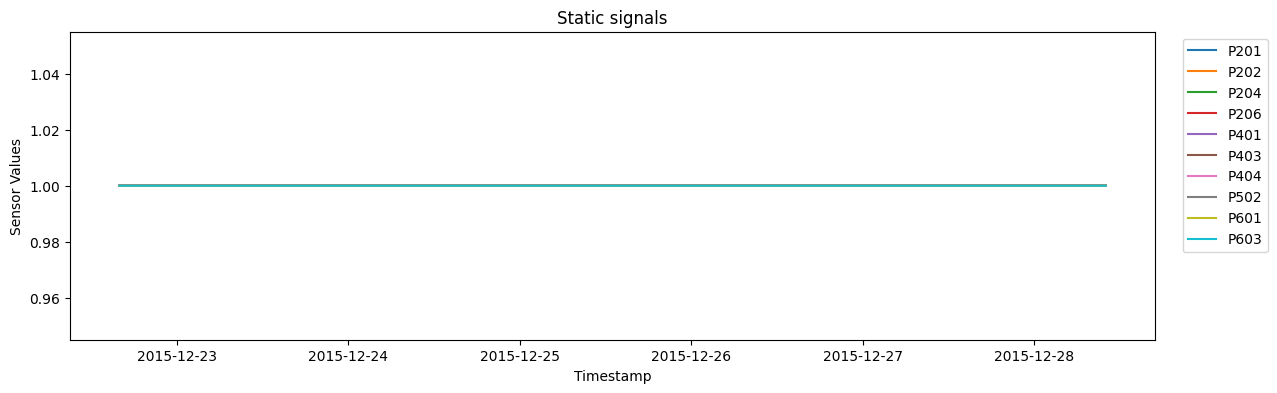

In [8]:
visualize_sensor_data(train_data, sensors=['P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603'], title="Static signals", figsize=(14,4))

#### 2. Integer binary signals
Signals like `P101, P203, P205, P301, P302, P402, UV401, P501, P602` all are either 1 or 2 throughout the data set.

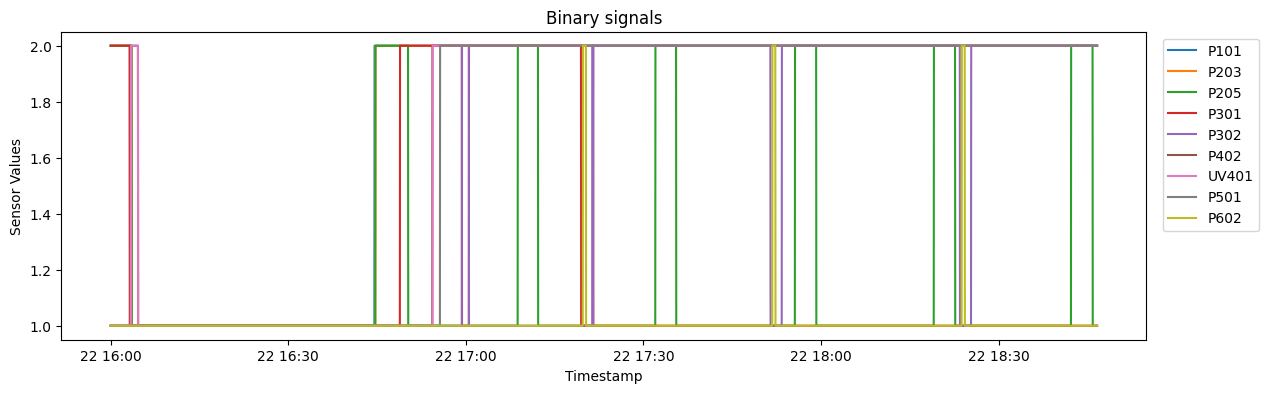

In [9]:
sensors = ['P101', 'P203', 'P205', 'P301', 'P302', 'P402', 'UV401', 'P501', 'P602']
visualize_sensor_data(train_data, window=(0, 10_000), sensors=sensors, title="Binary signals", figsize=(14,4))

#### 3. Float two-state signals
Signals like `FIT101, FIT201, FIT301, FIT401, FIT501, FIT502, FIT503, FIT504` vary between 0 and some higher value with either random noise, or some cyclic behaviour around that higher value.

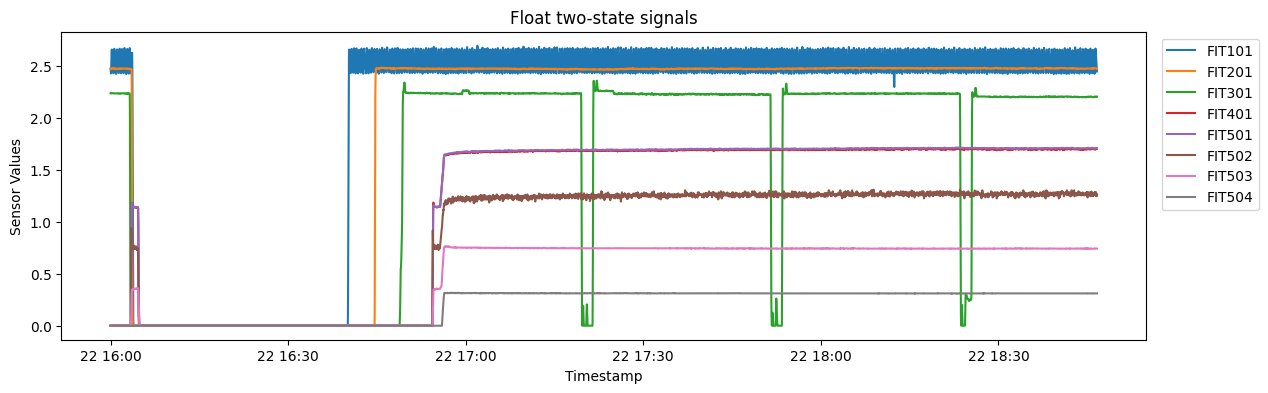

In [10]:
sensors = ['FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504']
visualize_sensor_data(train_data, window=(0, 10_000), sensors=sensors, title="Float two-state signals", figsize=(14,4))

`FIT101` seems to have a clear cyclic pattern at the high value, while others have seemingly random noise at their high values, as shown below.

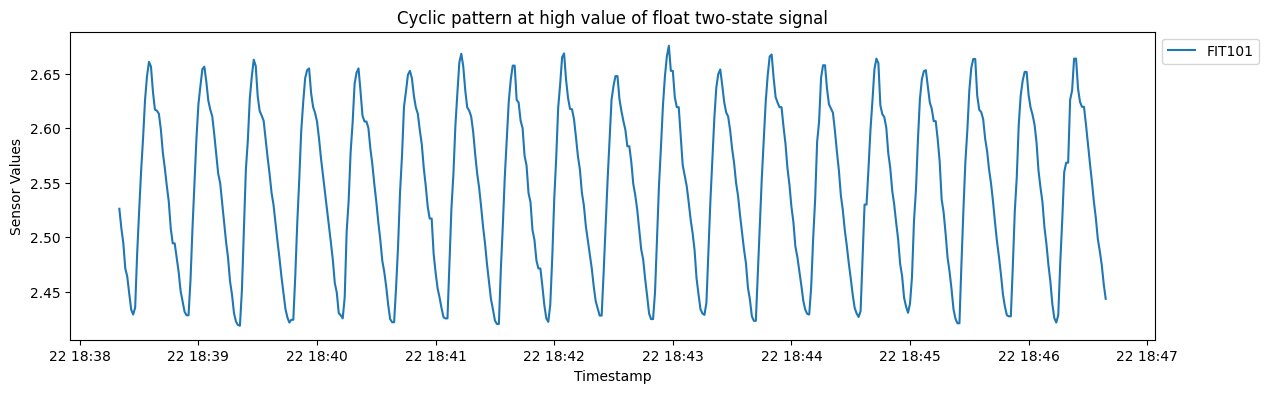

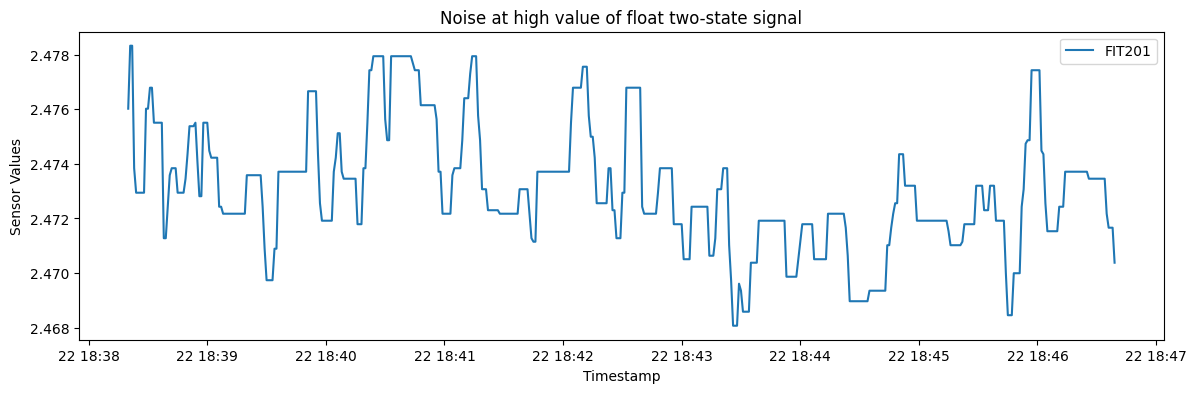

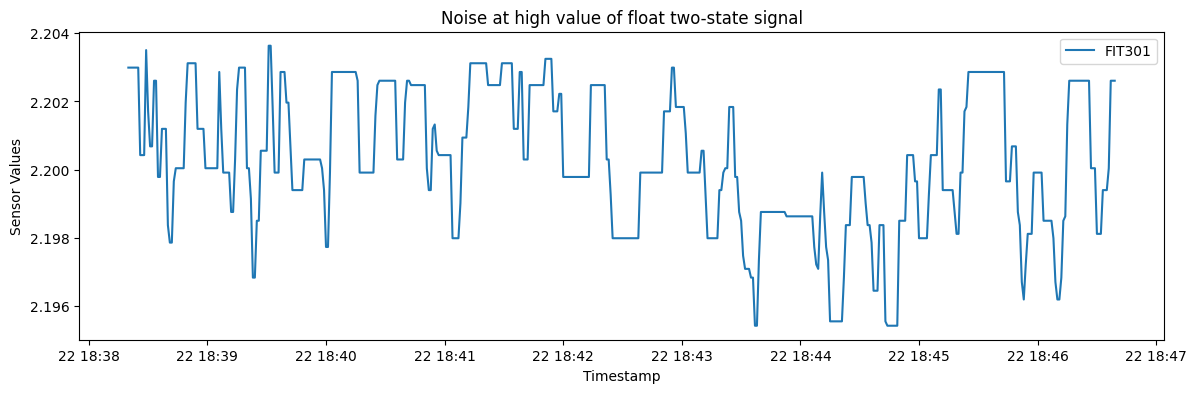

In [11]:
sensors = ['FIT101']
visualize_sensor_data(train_data, window=(9_500, 10_000), sensors=sensors, title="Cyclic pattern at high value of float two-state signal", figsize=(14,4))

sensors = ['FIT201']
visualize_sensor_data(train_data, window=(9_500, 10_000), sensors=sensors, title="Noise at high value of float two-state signal", figsize=(14,4))

sensors = ['FIT301']
visualize_sensor_data(train_data, window=(9_500, 10_000), sensors=sensors, title="Noise at high value of float two-state signal", figsize=(14,4))

As an aside, these signals look a lot like voltage readings on wires that encode some binary data or control signal. If that was the case, that might explain the noise, and even the cyclic behaviour of `FIT101`.

#### 4. Integer trinary signals
Signals like MV101, MV201, MV301, MV302, MV303, MV304 are trinary signals. They take on the values of 0, 1 or 2 throughout the data set.

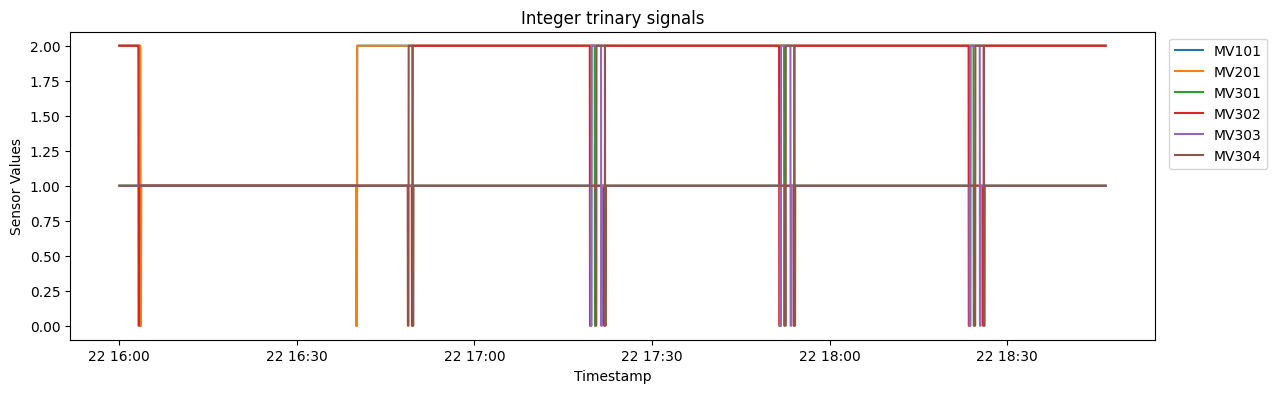

In [12]:
sensors = ['MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304']
visualize_sensor_data(train_data, window=(0, 10_000), sensors=sensors, title="Integer trinary signals", figsize=(14,4))

#### 5. Float analogue signals
Signals like `AIT201, AIT202, AIT203, AIT401, AIT402, AIT501, AIT502, AIT503, LIT101, LIT301, LIT401, DPIT301` are all floating point analogue signals.

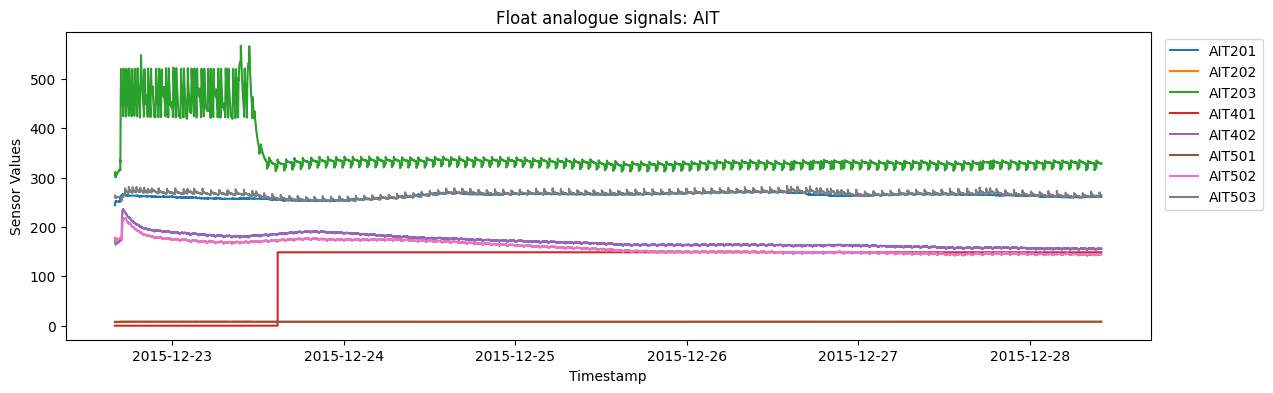

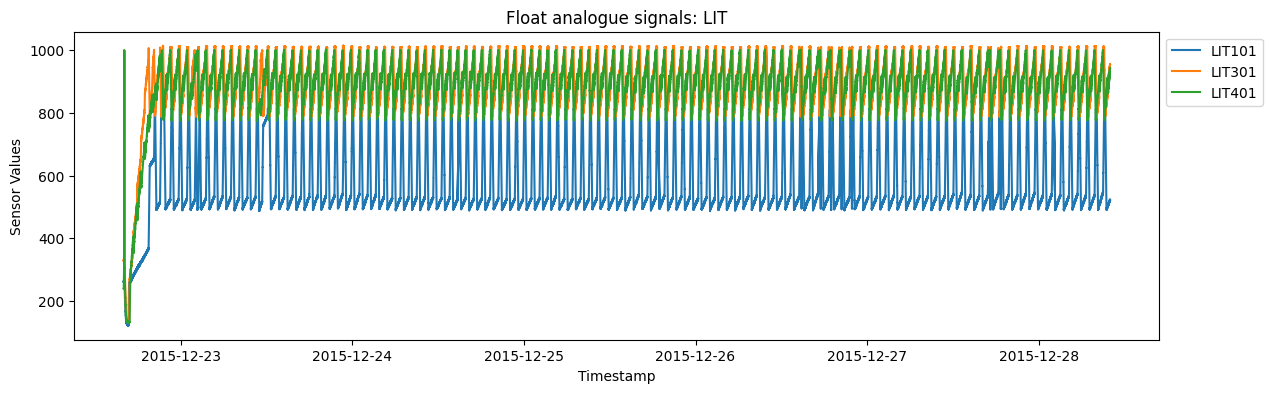

In [13]:
sensors = ['AIT201', 'AIT202', 'AIT203', 'AIT401', 'AIT402', 'AIT501', 'AIT502', 'AIT503']
visualize_sensor_data(train_data, sensors=sensors, title="Float analogue signals: AIT", figsize=(14,4))

sensors = ['LIT101', 'LIT301', 'LIT401']
visualize_sensor_data(train_data, sensors=sensors, title="Float analogue signals: LIT", figsize=(14,4))

### Signal correlation / behaviour
Some signals show clear correlation, and a lot of signals show clear cyclic behaviour.

#### LIT signals

The LIT signals show both clear correlation and cyclic behaviour. Below is the graph of the full data set for these sensors.

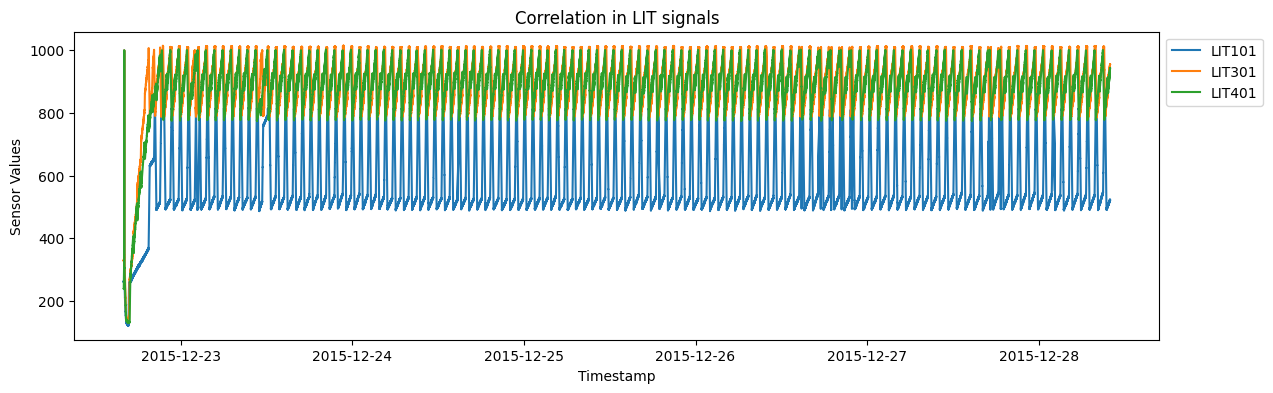

In [14]:
sensors = ['LIT101', 'LIT301', 'LIT401']
visualize_sensor_data(train_data, sensors=sensors, title="Correlation in LIT signals", figsize=(14,4))

From these graphs, we can see that the signals peak, fall, then rise together at the start.

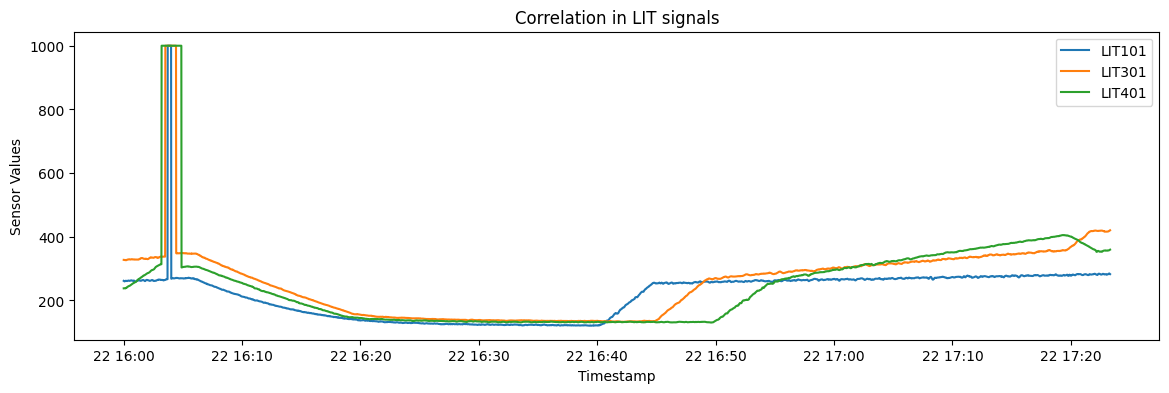

In [15]:
sensors = ['LIT101', 'LIT301', 'LIT401']
visualize_sensor_data(train_data, window=(0, 5_000), sensors=sensors, title="Correlation in LIT signals", figsize=(14,4))

After rising together, they cycle in a repeated, correlated pattern.

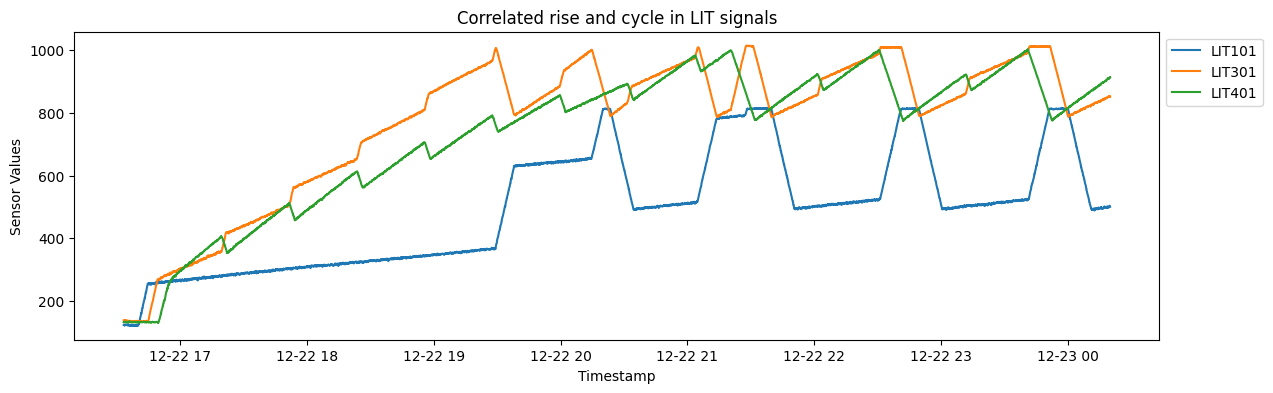

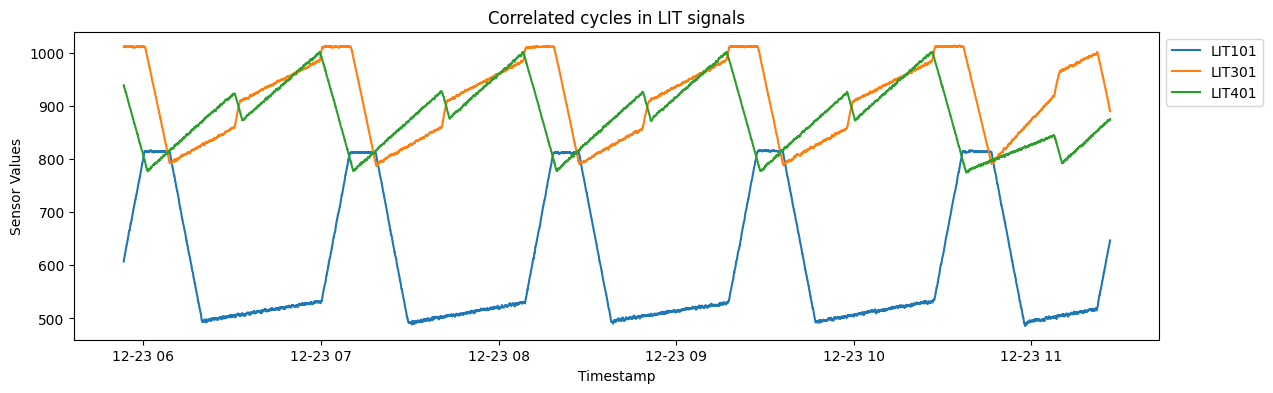

In [16]:
sensors = ['LIT101', 'LIT301', 'LIT401']
visualize_sensor_data(train_data, window=(2_000, 30_000), sensors=sensors, title="Correlated rise and cycle in LIT signals", figsize=(14,4))

sensors = ['LIT101', 'LIT301', 'LIT401']
visualize_sensor_data(train_data, window=(50_000, 70_000), sensors=sensors, title="Correlated cycles in LIT signals", figsize=(14,4))

#### FIT signals
Some FIT signals are also clearly correlated, but show no cyclic behaviour.

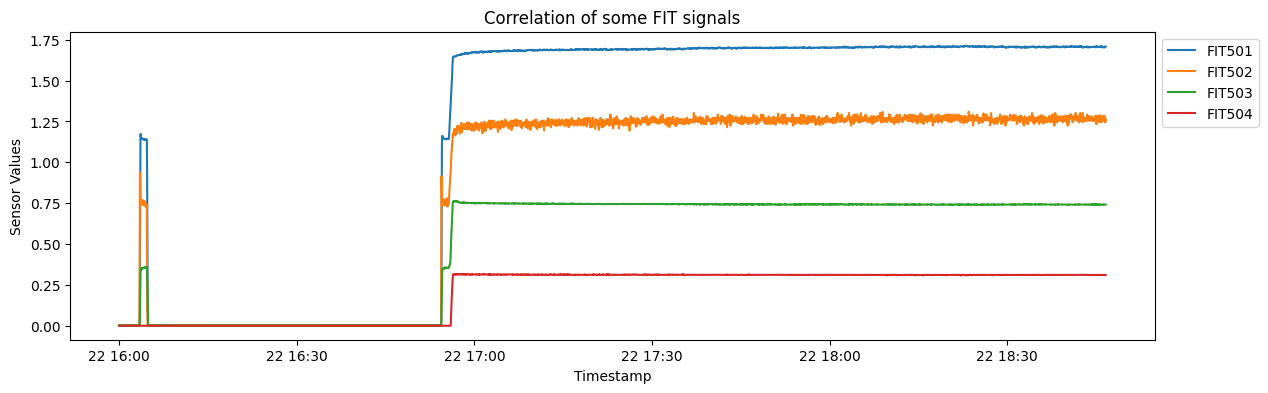

In [17]:
sensors = ['FIT501', 'FIT502', 'FIT503', 'FIT504']
visualize_sensor_data(train_data, window=(0, 10_000), sensors=sensors, title="Correlation of some FIT signals", figsize=(14,4))

`FIT301` shows cyclic behaviour, but did not seem to correlate to other FIT signals (as shown in graph "Float two-state signals")

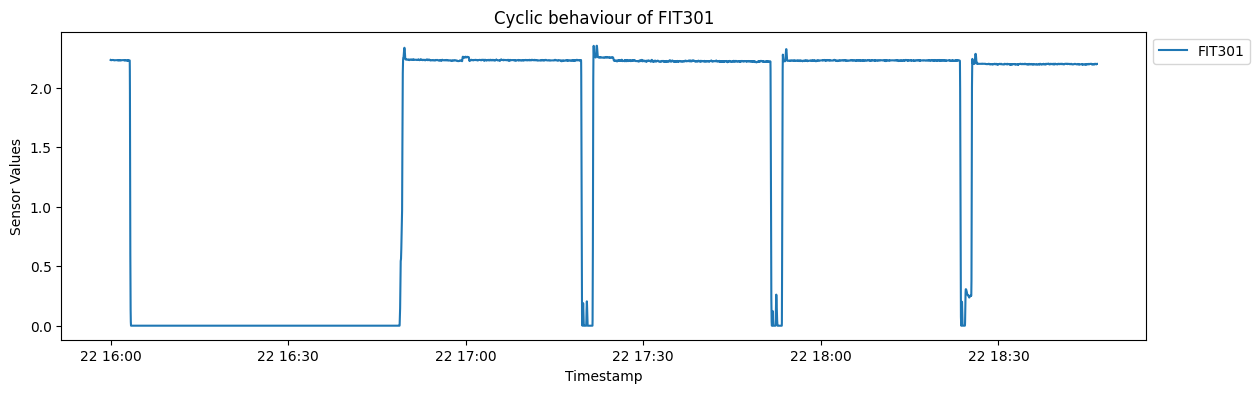

In [18]:
sensors = ['FIT301']
visualize_sensor_data(train_data, window=(0, 10_000), sensors=sensors, title="Cyclic behaviour of FIT301", figsize=(14,4))

#### AIT signals

Some AIT signals show clear cyclic patterns, and are also correlated to some degree.
Below is a visualisation to show the cyclic patterns that exist in some AIT signals

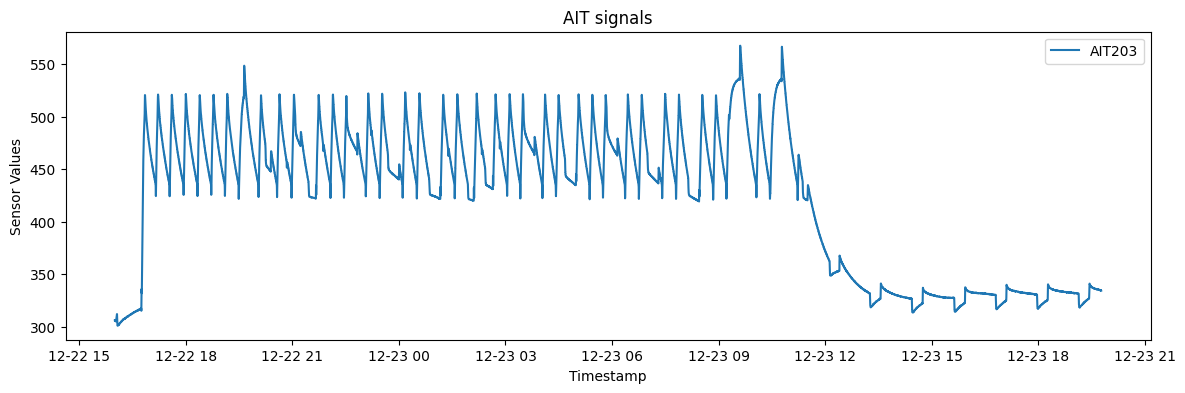

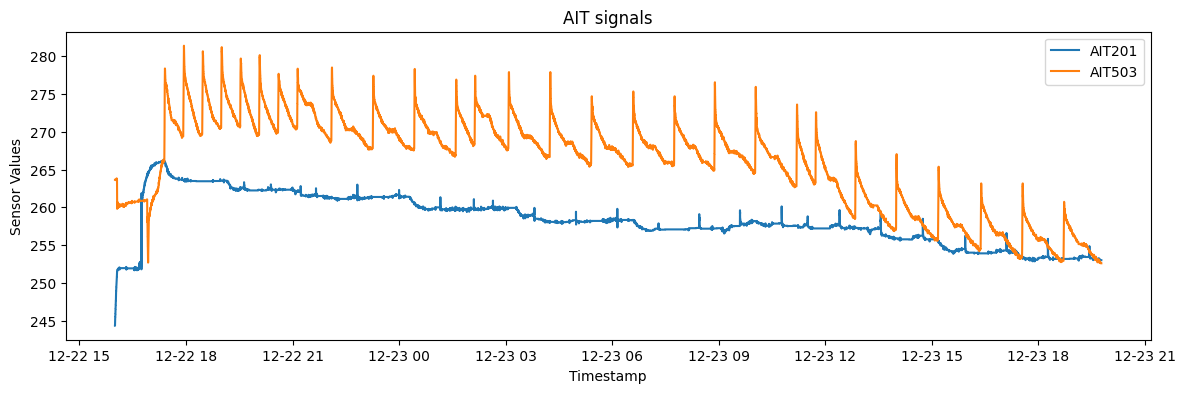

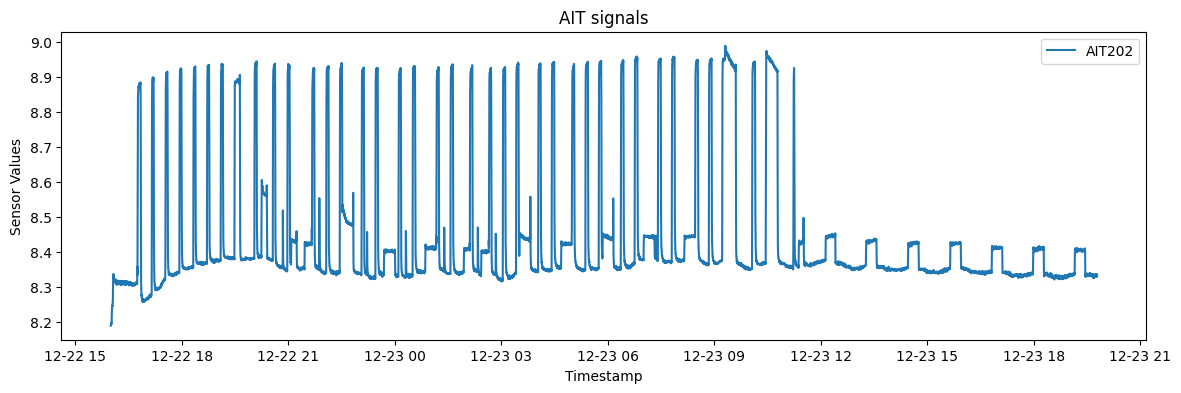

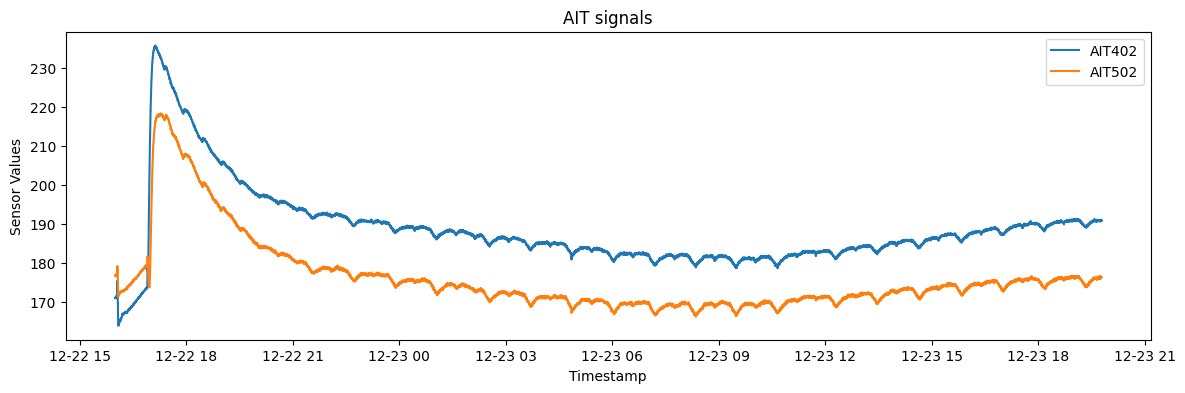

In [19]:
sensors = ['AIT203']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4), bbox_to_anchor=(1.0, 1.0))

sensors = ['AIT201', 'AIT503']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4), bbox_to_anchor=(1.0, 1.0))

sensors = ['AIT202']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4), bbox_to_anchor=(1.0, 1.0))

sensors = ['AIT402', 'AIT502']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4), bbox_to_anchor=(1.0, 1.0))

Some do not show cyclic behaviour.

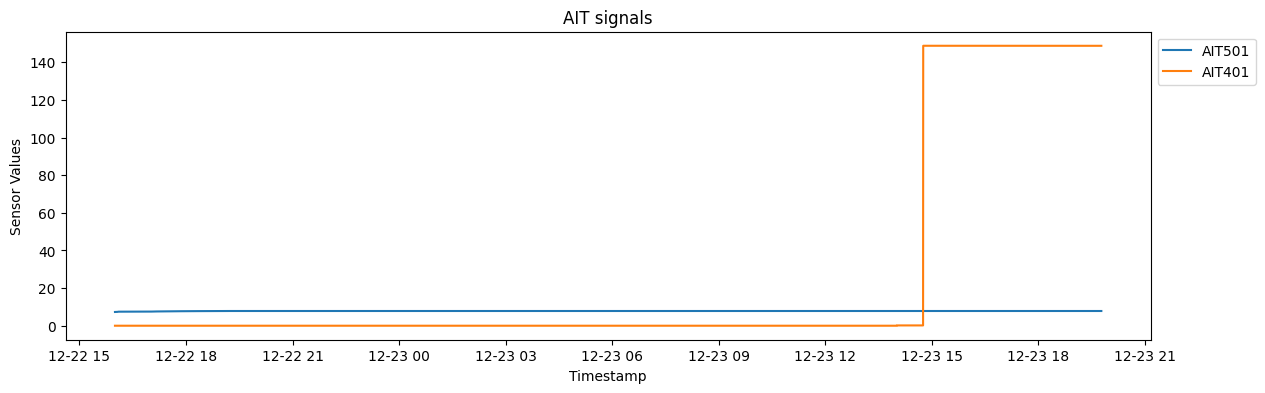

In [20]:
sensors = ['AIT501', 'AIT401']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4), bbox_to_anchor=(1.0, 1.0))

Some AIT signals show clear correlation, like `AIT202, AIT203, AIT503` cycling at high intensity to start, then all continuing to cycle at a lower intensity at a shared point.

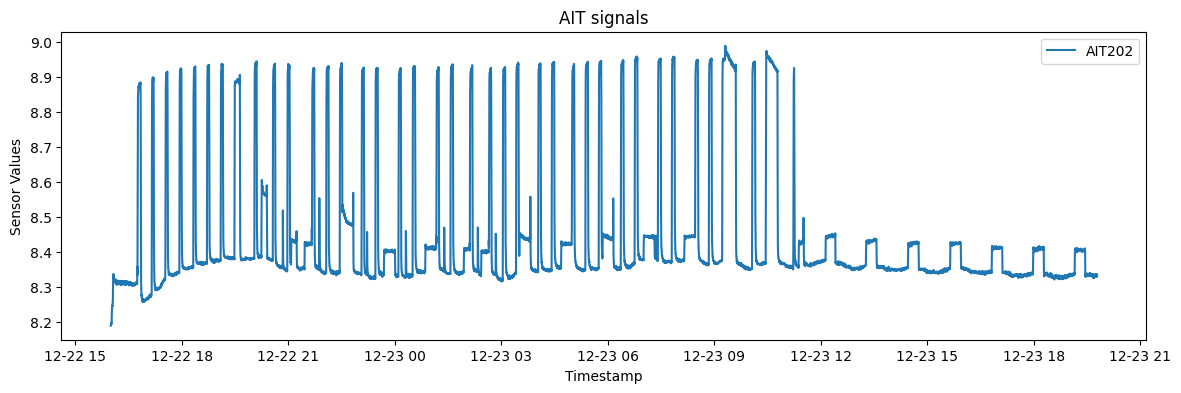

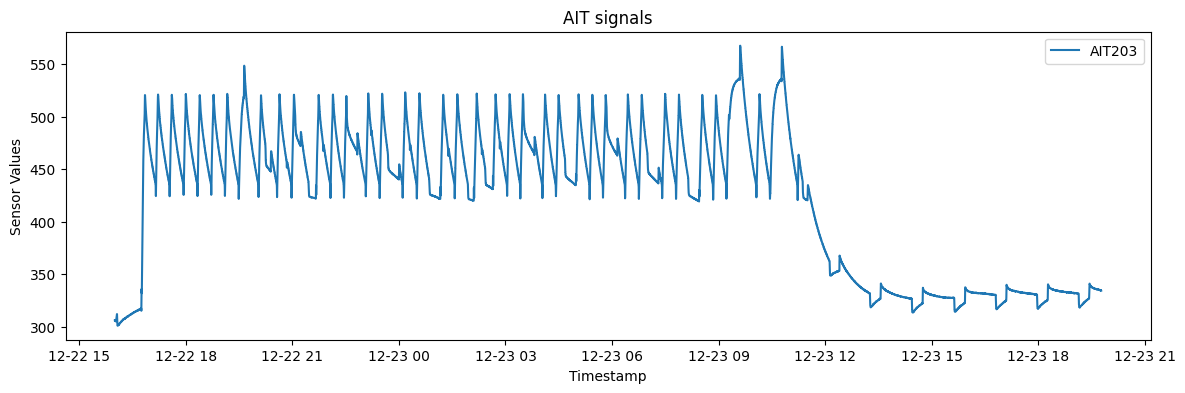

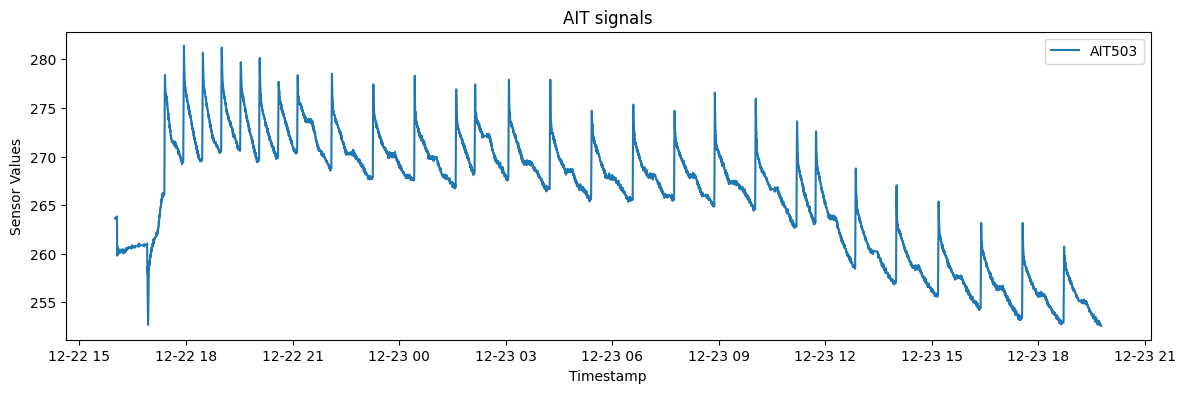

In [21]:
sensors = ['AIT202']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4))

sensors = ['AIT203']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4))

sensors = ['AIT503']
visualize_sensor_data(train_data, window=(0, 100_000), sensors=sensors, title="AIT signals", figsize=(14,4))

## DTW-based anomaly detection
To perform DTW-based anomaly detection, we will select one signal with interesting temporal behaviour to attempt the technique on. We will choose FIT101 for this purpose, at it has very steady cyclic behaviour. Because it is so steady, we expect it will make detecting anomalies easier. A sample of `FIT101` is graphed again below.

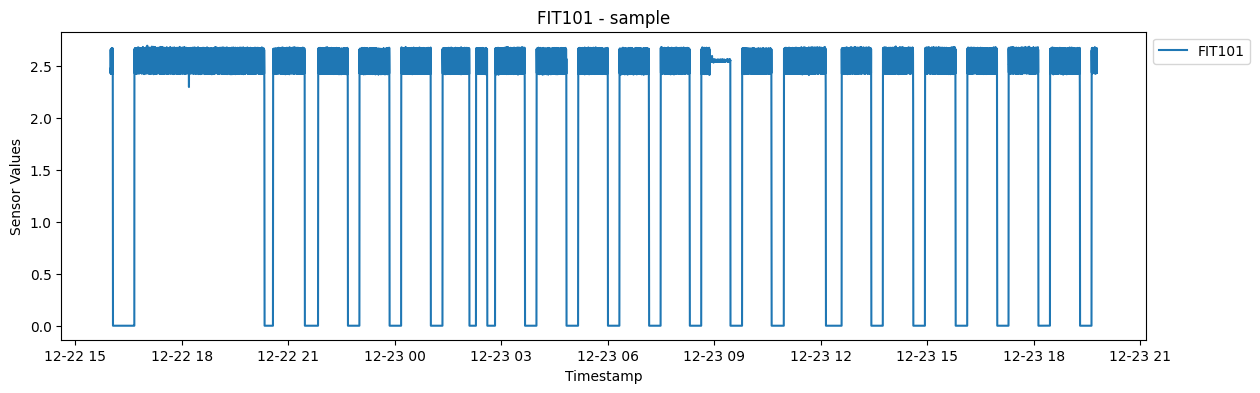

In [22]:
sensors = ['FIT101']
visualize_sensor_data(train_data, sensors=sensors, window=(0, 100_000), title="FIT101 - sample", figsize=(14,4))

We will build a set of sliding windows over a subset of the data to lower the amount of windows needed to represent the signal. This will speed up the runtime of the algorithm. The set of sliding widows will be built over the start of the dataset, capture cyclic behaviour, a falling edge and a rising edge. We need to capture all these patterns, otherwise it would incorrectly mark test data as an anomaly.

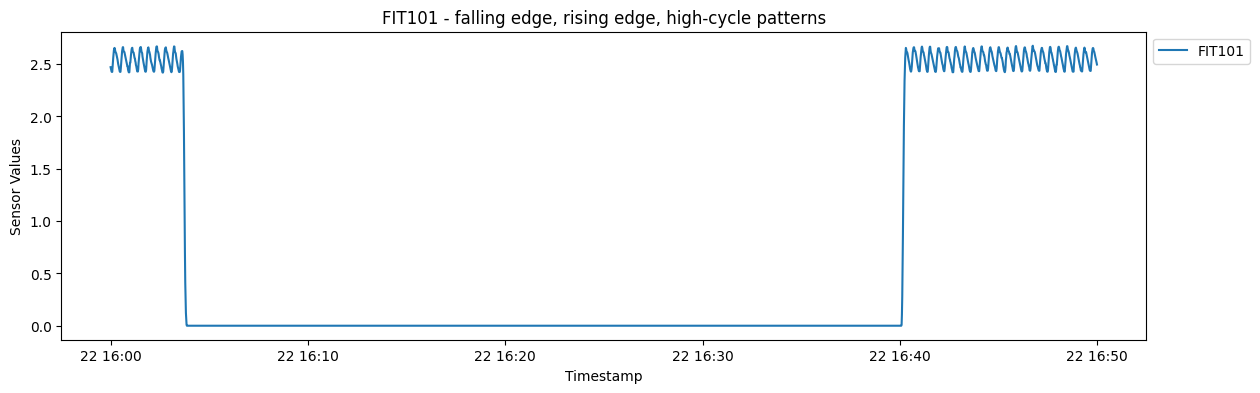

In [23]:
sensors = ['FIT101']
visualize_sensor_data(train_data, window=(0, 3_000), sensors=sensors, title="FIT101 - falling edge, rising edge, high-cycle patterns", figsize=(14,4))

There is also a piece of the training data where FIT101 shows a fourth pattern, other than the high cycle, falling edge and rising edge, which is a more stable high line, as shown below. We will also include this range in our sliding windows.

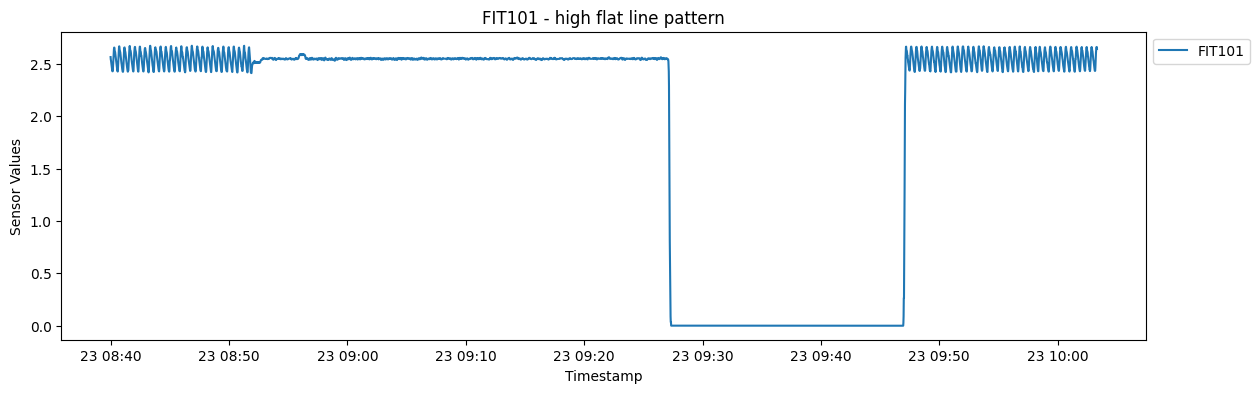

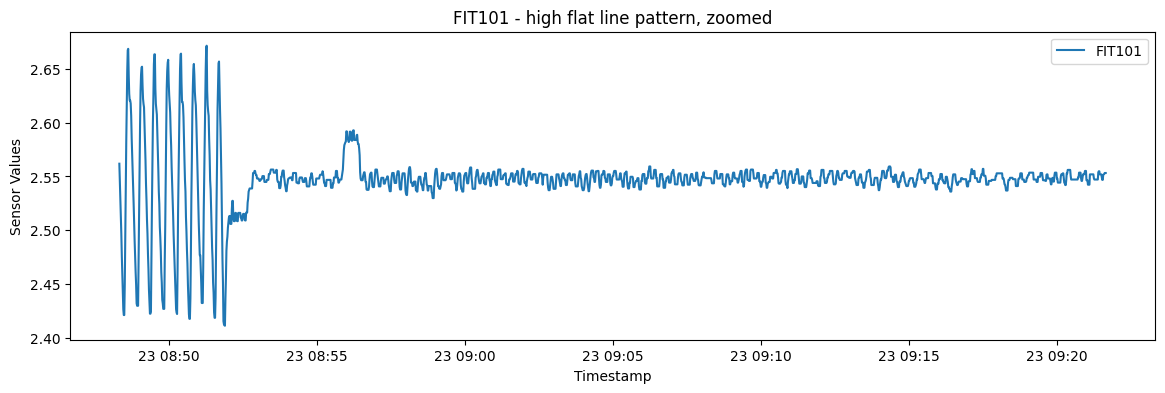

In [102]:
sensors = ['FIT101']
visualize_sensor_data(train_data, window=(60_000, 65_000), sensors=sensors, title="FIT101 - high flat line pattern", figsize=(14,4))
visualize_sensor_data(train_data, window=(60_500, 62_500), sensors=sensors, title="FIT101 - high flat line pattern, zoomed", figsize=(14,4))

Below are graphed the section of `FIT101` over which we will construct our sliding windows.

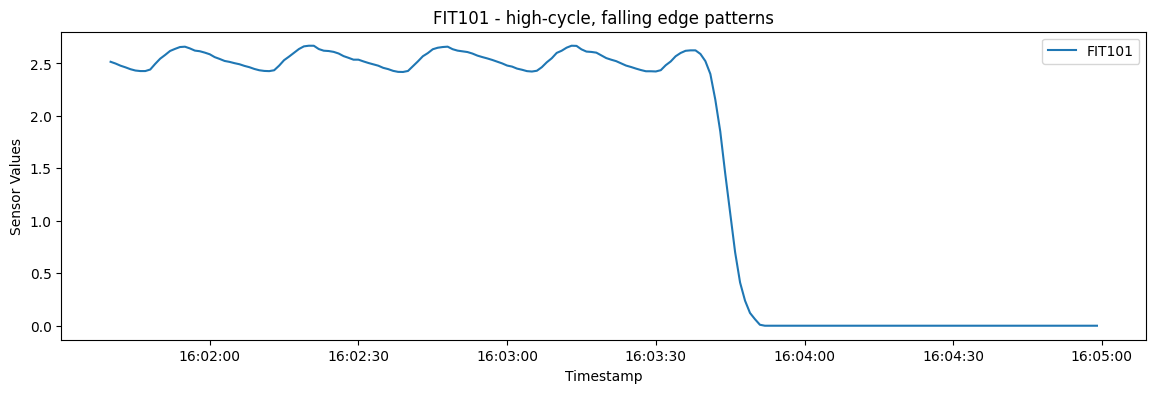

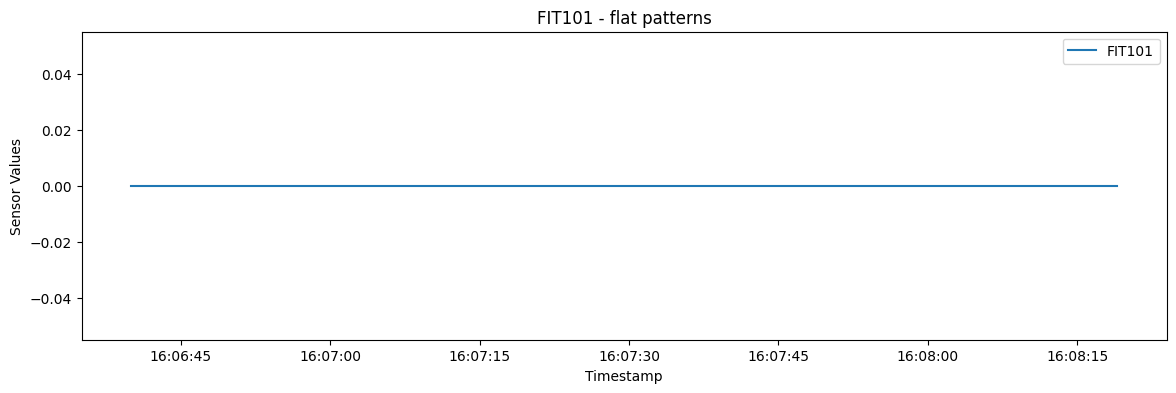

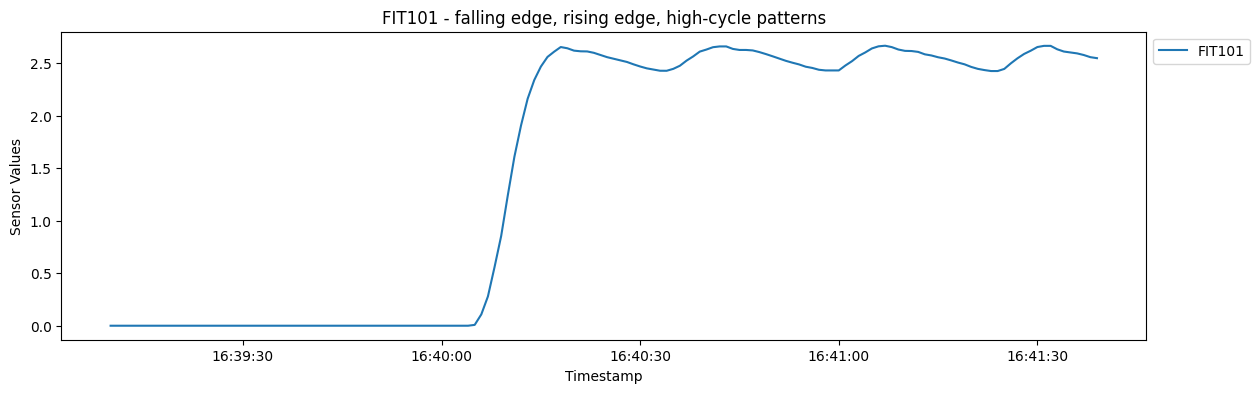

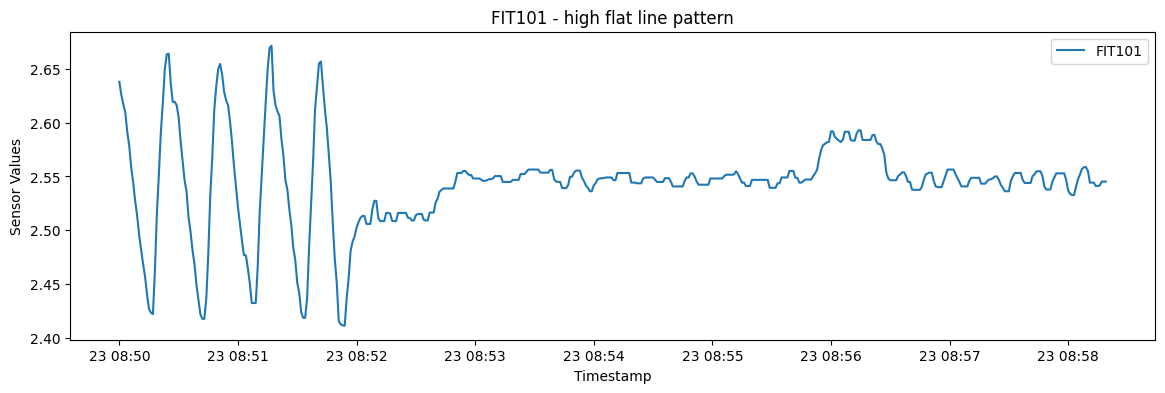

In [116]:
sensors = ['FIT101']
visualize_sensor_data(train_data, window=(100, 300), sensors=sensors, title="FIT101 - high-cycle, falling edge patterns", figsize=(14,4))
visualize_sensor_data(train_data, window=(400, 500), sensors=sensors, title="FIT101 - flat patterns", figsize=(14,4))
visualize_sensor_data(train_data, window=(2_350, 2_500), sensors=sensors, title="FIT101 - falling edge, rising edge, high-cycle patterns", figsize=(14,4))
visualize_sensor_data(train_data, window=(60_600, 61_100), sensors=sensors, title="FIT101 - high flat line pattern", figsize=(14,4))

We're choosing a length of 100 and a stride of 25. The length is chosen to capture about 4 oscillations in a sliding window, and the stride of 25 is chosen to overlap the windows significantly, to respectively capture many permutations and different phases of the cyclic pattern. Using these values, we're also capturing regions of the cyclic pattern in combination with the rising and falling edges before and after the cyclic pattern, respectively.

In [100]:
def get_windows(data, sensor: str, length: int, stride: int, window = None):
    if window is None:
        start_index, end_index = 0, len(data)
    else:
        start_index, end_index = window
    
    array = data[sensor].to_numpy()[start_index:end_index]

    windows = np.lib.stride_tricks.sliding_window_view(array, length)
    windows = windows[0::stride]

    return windows

# Obtain windows into FIT101 training data
window_set_1 = get_windows(train_data, sensor='FIT101', window=(100, 300), length=100, stride=25)
window_set_2 = get_windows(train_data, sensor='FIT101', window=(400, 500), length=100, stride=25)
window_set_3 = get_windows(train_data, sensor='FIT101', window=(2_350, 2_500), length=100, stride=25)
window_set_4 = get_windows(train_data, sensor='FIT101', window=(60_600, 61_100), length=100, stride=25)
window_set = np.concatenate((window_set_1, window_set_2, window_set_3, window_set_4))
print(f"We now have a representative set of {window_set.shape[0]} sliding windows over our data")

def compare_window_to_window_set(window_set, window):
    # print(window_set.shape)
    # print(window.shape)
    min_distance = np.inf
    min_index = None
    
    for i in range(0, window_set.shape[0]):
        compare_window = window_set[i]
        distance = dynamic_time_warping(window, compare_window)
        
        if distance < min_distance:
            min_distance = distance
            min_index = i
    
    return min_distance


We now have a representative set of 26 sliding windows over our data


Now that we have a set of representative sliding windows, we can start testing the training data set and the test data set against our sliding windows. For runtime reasons, we're only taking a subset of about a quarter of the data to test for anomalies.

This calculation should take about 6-8 minutes.

In [57]:
# This cell should take about 6-8 minutes to execute on a decent computer

data_window_length = 100
data_window_stride = 100
training_windows = get_windows(train_data, window=(0, 100_000), sensor="FIT101", length=data_window_length, stride=data_window_stride)
test_windows = get_windows(test_data, window=(0, 100_000), sensor="FIT101", length=data_window_length, stride=data_window_stride)

print("Computing distances for training and test set first 100 000 datapoints to our set of sliding windows")

distances_train = []
for i in range(0, training_windows.shape[0]):
    if i % 50 == 0:
        print(f"{i/training_windows.shape[0]*100}% done - training set")
    distances_train.append(compare_window_to_window_set(window_set, training_windows[i]))
print("Done")

distances_test = []
for i in range(0, test_windows.shape[0]):
    if i % 50 == 0:
        print(f"{i/test_windows.shape[0]*100}% done - test set")
    distances_test.append(compare_window_to_window_set(window_set, test_windows[i]))
print("Done")


Computing distances for training set and test set first 100 000 datapoints to our set of sliding windows
0.0% done - training set
5.0% done - training set
10.0% done - training set
15.0% done - training set
20.0% done - training set
25.0% done - training set
30.0% done - training set
35.0% done - training set
40.0% done - training set
45.0% done - training set
50.0% done - training set
55.00000000000001% done - training set
60.0% done - training set
65.0% done - training set
70.0% done - training set
75.0% done - training set
80.0% done - training set
85.0% done - training set
90.0% done - training set
95.0% done - training set
Done
0.0% done - test set
5.0% done - test set
10.0% done - test set
15.0% done - test set
20.0% done - test set
25.0% done - test set
30.0% done - test set
35.0% done - test set
40.0% done - test set
45.0% done - test set
50.0% done - test set
55.00000000000001% done - test set
60.0% done - test set
65.0% done - test set
70.0% done - test set
75.0% done - test 

Now that the distances are calculated, we can plot the distances of all sliding windows to the closest matching sliding window in our representative set. We can see that the distances are very small, which may mean that there are no anomalous data points in the training and test data ranges that we looked analysed, or the anomalies are very small. We will investigate further.

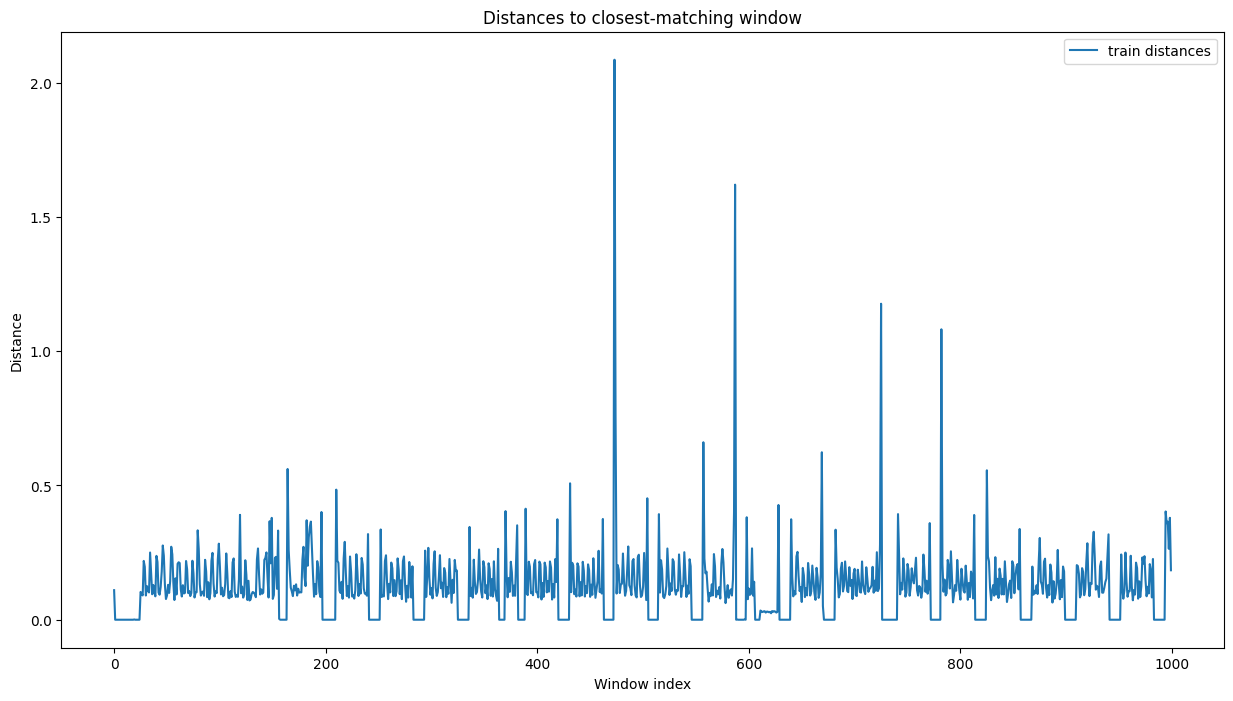

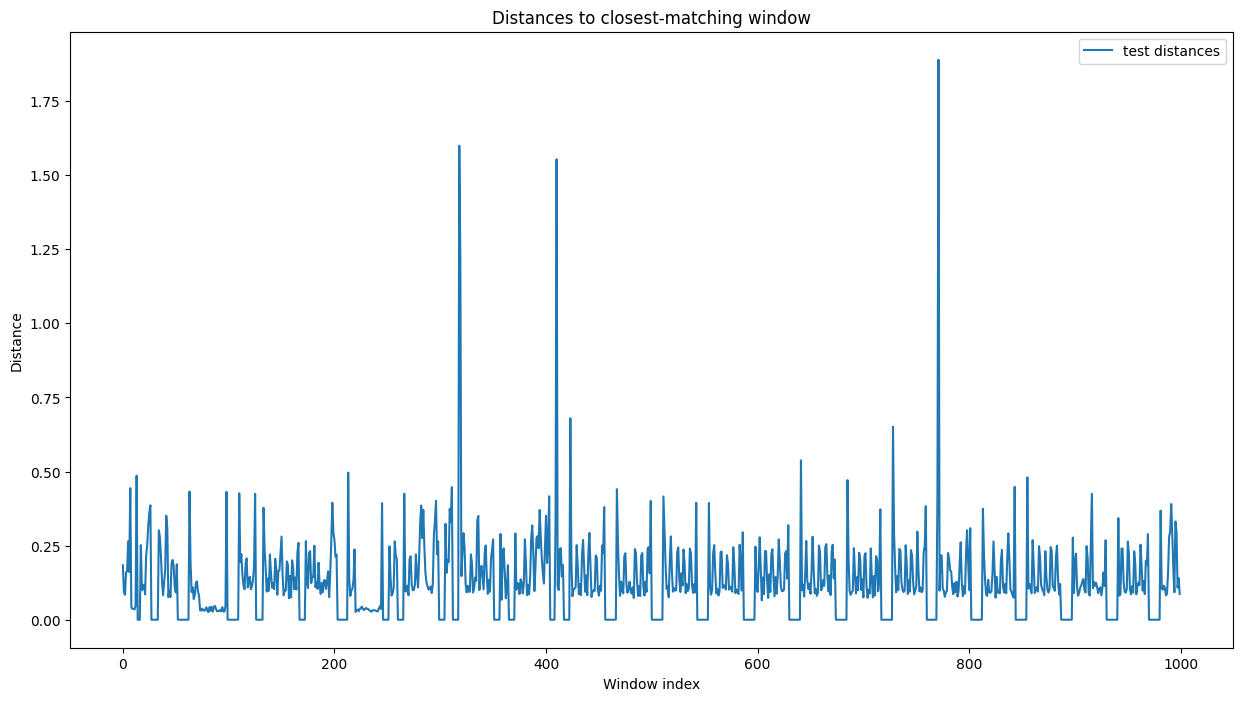

In [101]:
df_train = pd.DataFrame({
    "train distances": distances_train,
})
df_test = pd.DataFrame({
    "test distances": distances_test
})
df_train['Index'] = range(0, len(df_train))
columns = df_train.columns.to_list()
columns = columns[-1:] + columns[:-1]
df_train = df_train[columns]

df_test['Index'] = range(0, len(df_test))
columns = df_test.columns.to_list()
columns = columns[-1:] + columns[:-1]
df_test = df_test[columns]

# print(df_train)
# print(df_test)

def plot(df, columns = None):
    if columns == None:
        columns = df.columns[1:]

    plt.figure(figsize=(15, 8))
    for column in columns:
        plt.plot(df["Index"], df[column], label=column)

    plt.xlabel('Window index')
    plt.ylabel('Distance')
    plt.title("Distances to closest-matching window")

    loc = 'best'
    bbox_to_anchor = (1.0, 1.0)
    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)
    plt.show()
plot(df_train, ["train distances"])
plot(df_test, ["test distances"])

To see what the anomalies look like, we must calculate the start and end index of the data based on the sliding window index that contained an anomaly. We will consider a distance of 1 or higher to be potentially anomalous, because the clearest peaks in the above graphs can be seen peaking above 1. We want to take a closer look at the data near those distance peaks. Below are graphed the four potential anomalies in the training data that we found.

Window 474 and 588 look benign. The large distance may have been the low slope of the line near the bottom datapoints.

Training data window 726 and 783 do look interesting. Both look to contain one contextual anomaly where one datapoint is higher than the expected near-linear behaviour of the surrounding datapoints.

Found 4 anomalies in training data


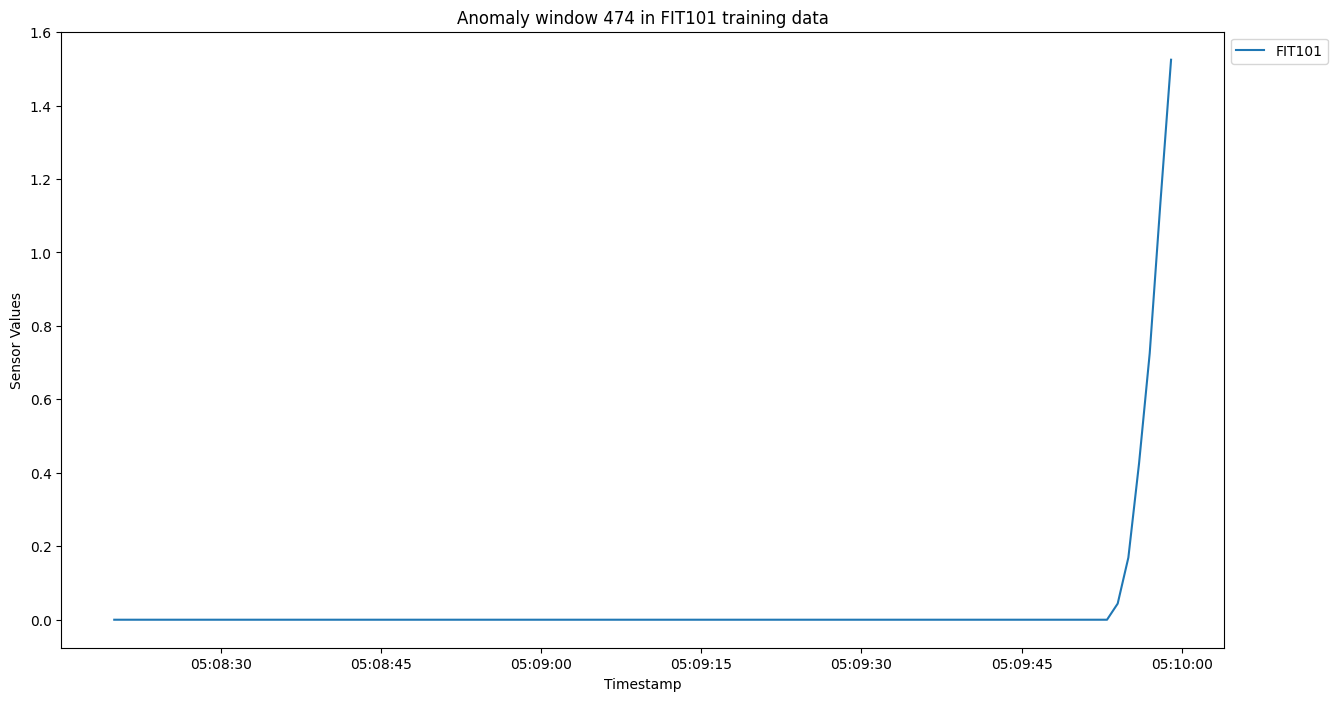

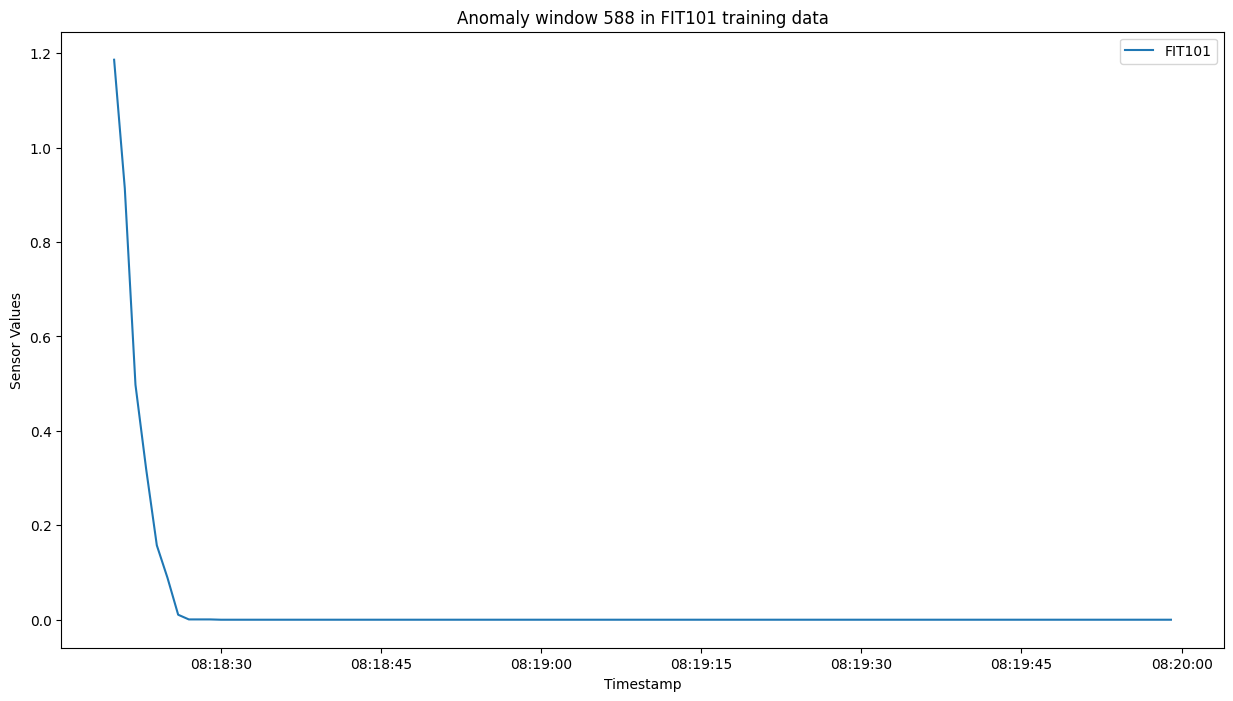

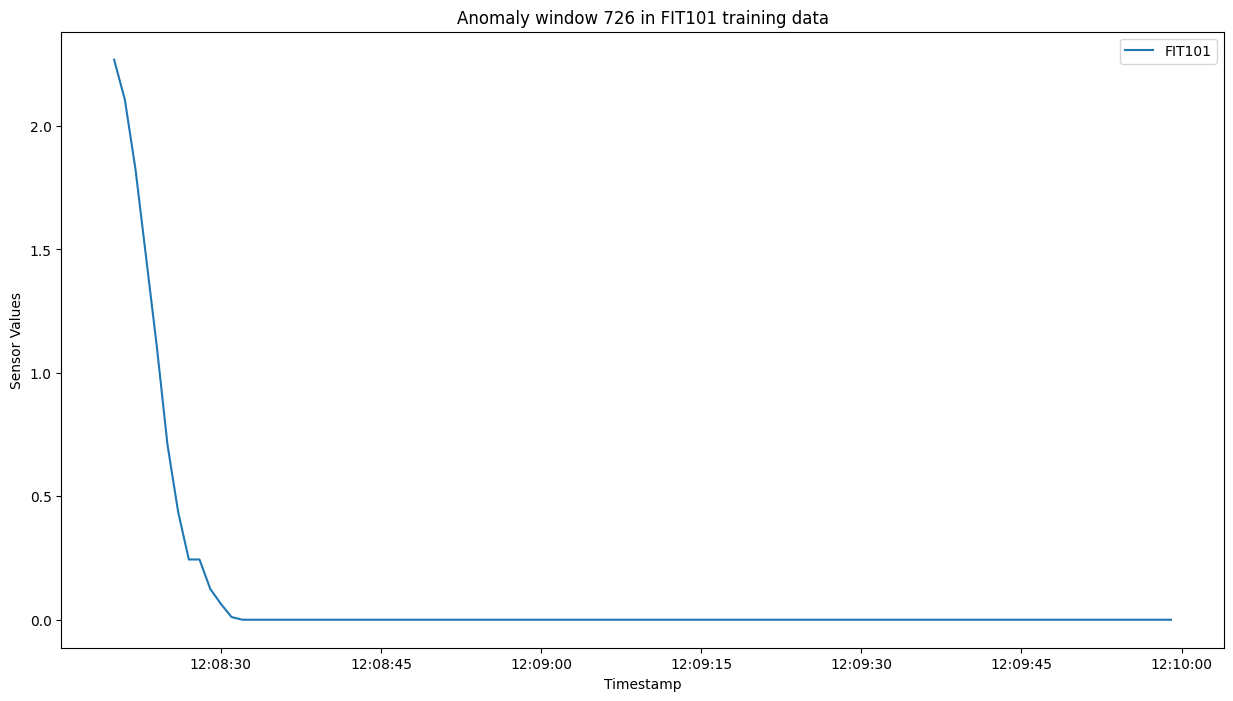

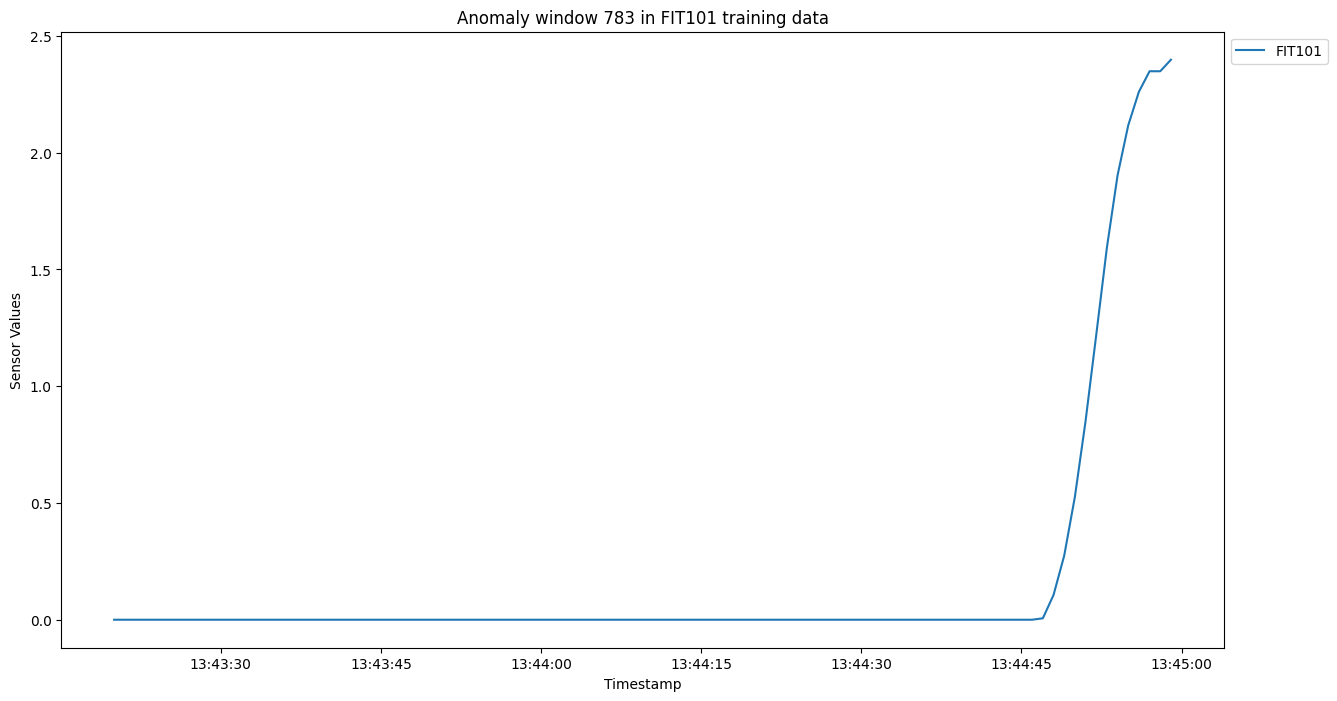

In [105]:
cols = ['train distances']
df_train_filtered = df_train.copy()
df_train_filtered[cols] = df_train_filtered[df_train_filtered[cols] > 1][cols]
df_train_filtered = df_train_filtered.dropna()

print(f"Found {len(df_train_filtered)} anomalies in training data")

for i in df_train_filtered["Index"]:
    start_index = i * data_window_stride
    end_index = start_index + data_window_length
    visualize_sensor_data(train_data, window=(start_index, end_index), sensors=["FIT101"], title=f"Anomaly window {i+1} in FIT101 training data")

Now to look at the four anomalies in the test data set that we found. Window 319 looks benign.

Window 320 does seem to contain a similar anomaly as 726 and 783 in the training data, of one contextual anomaly of a point being out of alignment with the near-linear behaviour of the surrounding points.

Windows 411 and 772 are the most interesting. Here the data line rises very slowly, or even drops in the case of 772, in the first cycle of the high value. Both of these are also contextual anomalies. Given the data set we chose to construct our sliding windows, our rising edge rises smoothly to the top without dropping, or slowing down and speeding up again as in 411. It is not a major deviation, but we would have expected to also detect this anomaly in the training data if it existed there.

Since we did not detect a similar anomaly in the training data, we can assume that these two windows of data are actual anomalies. 

Found 4 anomalies in test data


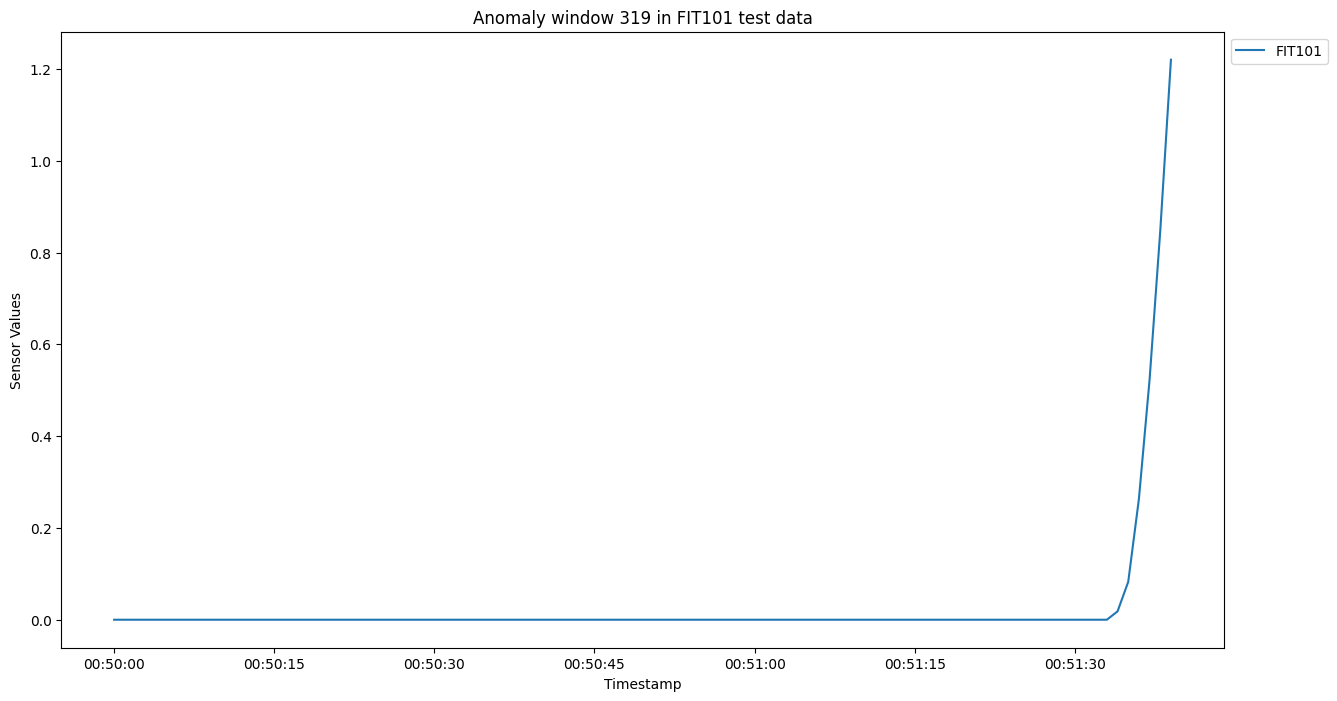

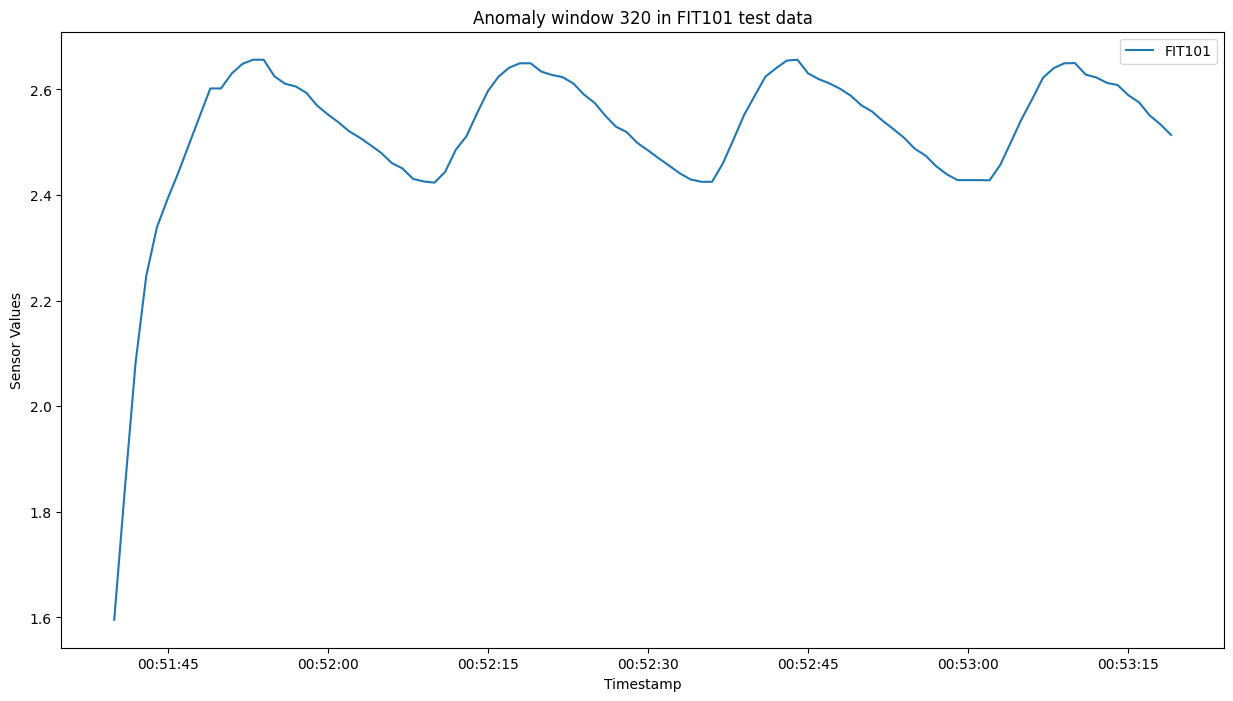

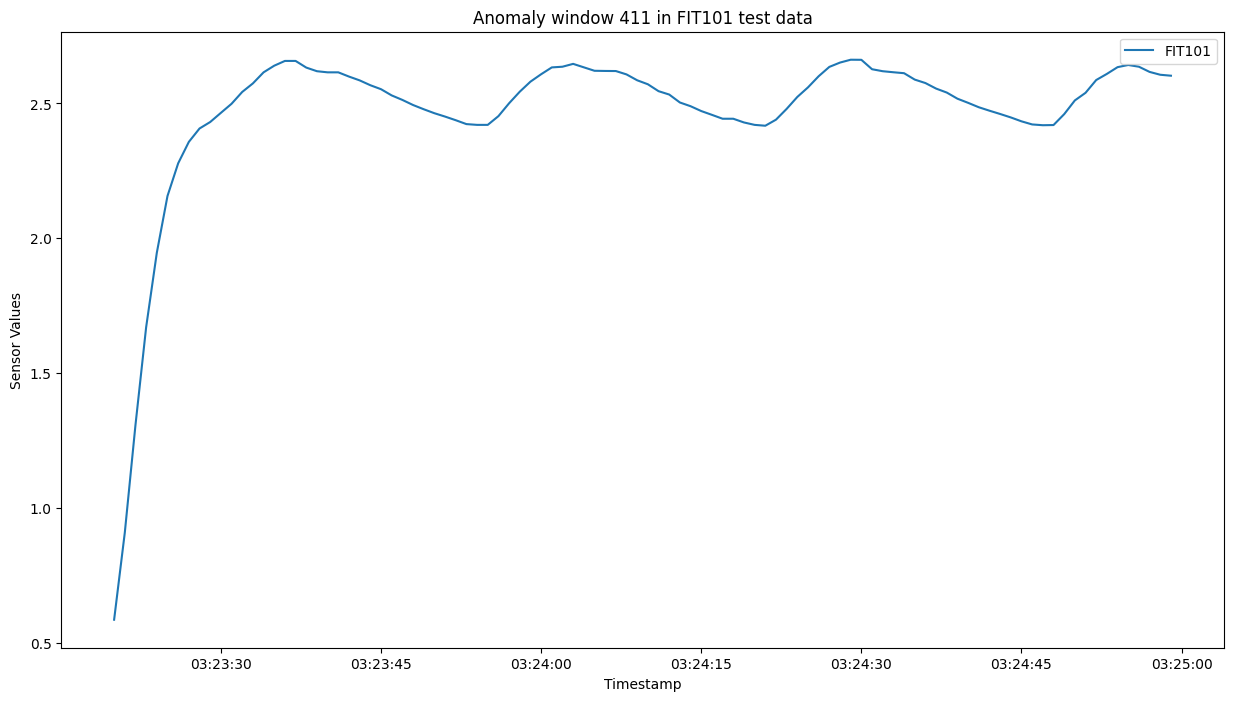

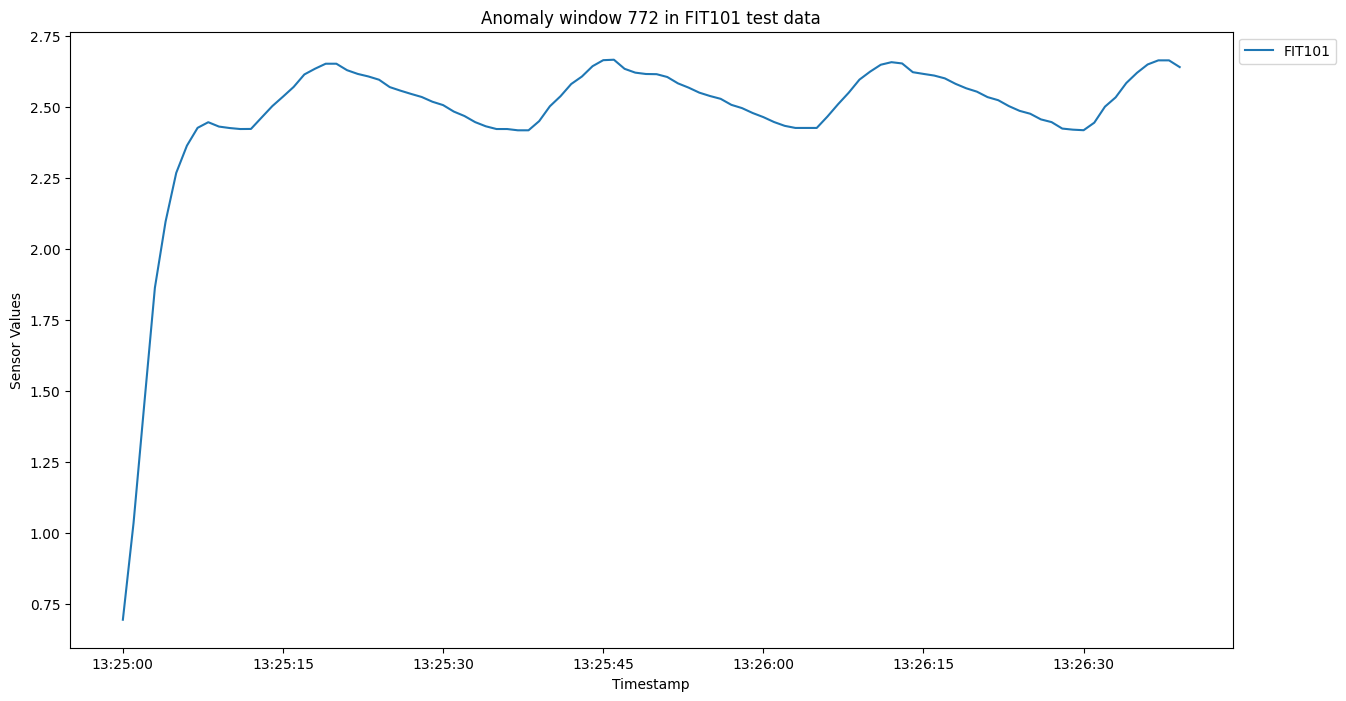

In [107]:
cols = ['test distances']
df_test_filtered = df_test.copy()
df_test_filtered[cols] = df_test_filtered[df_test_filtered[cols] > 1][cols]
df_test_filtered = df_test_filtered.dropna()
print(f"Found {len(df_test_filtered)} anomalies in test data")

for i in df_test_filtered["Index"]:
    start_index = i * data_window_stride
    end_index = start_index + data_window_length
    visualize_sensor_data(test_data, window=(start_index, end_index), sensors=["FIT101"], title=f"Anomaly window {i+1} in FIT101 test data")

It should be noted that none of these anomalies are very major, at least not as major as we expected to be able to find.

It could be the case that this sensor in particular is too consistent, and in hindsight a different sensor could have been better to investigate. After all the work done, we can't afford to change this choice now.

It might also be the case that the fourth pattern we identified and included in our model was an anomaly, and by including it in our training sliding windows, we're actually misidentifying it as normal behaviour. However, all the available training data is labeled as "Normal" instead of "Attack", and this pattern was present in the training data, so if it is anomalous, the data is mislabeled here.

## PCA-based anomaly detection

PCA exercise skipped for time reasons, apologies. Algorithm implementation is done above, and passing all spec tests on WebLab.

# End of Report

Some code snippets below preserved for posterity.

In [114]:
%%script echo skipping
# visualize_sensor_data(train_data, window=(0, 50000), sensors=['FIT101'])
# visualize_sensor_data(train_data, window=(0, 50000), sensors=['LIT101'])
# visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
# visualize_sensor_data(train_data)
# visualize_sensor_data(test_data)

# sensors = ['LIT101', 'LIT301']
sensors = train_data.columns

for sensor in sensors:
    visualize_sensor_data(train_data, window=(0, 100_000), sensors=[sensor])
    # visualize_sensor_data(test_data, sensors=[sensor])

Couldn't find program: 'echo'


In [113]:
%%script echo skipping
for i in train_data['P404']:
    if i != 1:
        print(f"Not 1: {i}")
        
for c in train_data.columns:
    dtype = train_data[c].dtype
    print(f"{c}: {dtype}")

Couldn't find program: 'echo'


In [112]:
%%script echo skipping
# for i in range(0, 1000):
#     print(train_data['FIT301'][i])
visualize_sensor_data(train_data, window=(8000, 10000), sensors=["AIT501"])

Couldn't find program: 'echo'
